# Sea Surface Temperature (SST) sensors
This notebook demonstrates how to use `PySensors` to perform optimal sensor placement for the NOAA sea surface temperature (SST) dataset.

Given a set of snapshots of the sea surface temperature as training data, we would like to choose locations to place sensors that collectively allow us to predict (or reconstruct) the temperature at any other point on the ocean. We'll show how to use the `SSPOR` class to efficiently solve this problem.

See the following [paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8361090) to learn about the mathematical background behind this approach:

    Manohar, Krithika, et al. "Data-driven sparse sensor placement for reconstruction: Demonstrating the benefits of exploiting known patterns." IEEE Control Systems Magazine 38.3 (2018): 63-86.


**Note:** running this notebook requires a ~200MB file download and for you to install the additional package `netCDF4`.

In [1]:
from ftplib import FTP

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import netCDF4

import pysensors as ps

## Load data
Import latest NOAA-SST weekly means (1990-present), published online in netCDF format

In [2]:
# Import and save data locally
ftp = FTP('ftp.cdc.noaa.gov')
ftp.login()
ftp.cwd('/Datasets/noaa.oisst.v2/')

filenames = ['sst.wkmean.1990-present.nc', 'lsmask.nc']

for filename in filenames:
    localfile = open(filename, 'wb')
    ftp.retrbinary('RETR ' + filename, localfile.write, 1024)
    localfile.close()

ftp.quit();

In [3]:
f = netCDF4.Dataset('sst.wkmean.1990-present.nc')

lat,lon = f.variables['lat'], f.variables['lon']
SST = f.variables['sst']
sst = SST[:]

f = netCDF4.Dataset('lsmask.nc')
mask = f.variables['mask']

### Plot a snapshot

Plot the first snapshot in the time series.

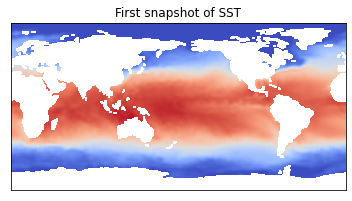

In [4]:
masks = np.bool_(np.squeeze(mask))
snapshot = float("nan")*np.ones((180,360))
snapshot[masks] = sst[0,masks]

plt.imshow(snapshot, cmap=plt.cm.coolwarm)
plt.xticks([])
plt.yticks([])
plt.title('First snapshot of SST')
X = sst[:,masks]
X = np.reshape(X.compressed(), X.shape) # convert masked array to array

## Optimal sensor placement
Use a `SSPOR` instance to determine optimal sensor locations, projecting the data onto 25 SVD modes. We select 25 sensors in this example.

In [5]:
model = ps.SSPOR(
    basis=ps.basis.SVD(n_basis_modes=25),
    n_sensors=25
)
model.fit(X)
sensors = model.get_selected_sensors()

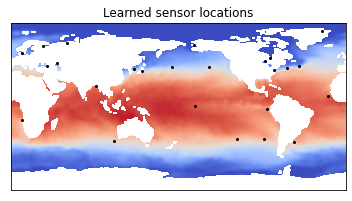

In [6]:
# Plot sensor locations
temp = np.transpose(0 * X[1,:])
temp[sensors] = 1
img = 0*snapshot
img[masks] = temp
plt.imshow(snapshot, cmap=plt.cm.coolwarm)
indx = np.where(img==1)
plt.scatter(indx[1], indx[0], 4, color='black')
plt.xticks([])
plt.yticks([])
plt.title('Learned sensor locations');

Note that many of the sensor locations lie along interfaces between hotter and cooler regions of the ocean.